In [1]:
# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import numpy as np
import math

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


input_path = '../Daniel_inputs/block_model.csv'
MB = pd.read_csv(input_path)

In [3]:
ejex_MB = MB.sort_values(by=['xcentre'],ascending=False)[['xcentre']]
ejey_MB = MB.sort_values(by=['ycentre'],ascending=False)[['ycentre']]
ejez_MB = MB.sort_values(by=['zcentre'],ascending=False)[['zcentre']]
pos_x_MB = np.unique(ejex_MB.values)
pos_y_MB = np.unique(ejey_MB.values)
pos_z_MB = np.unique(ejez_MB.values)

In [28]:
cols = MB.keys().tolist()
print('Nombres de las columnas:',cols)

Nombres de las columnas: ['xcentre', 'ycentre', 'zcentre', 'calcosina', 'cut', 'cufe', 'rec_max_block']


In [47]:
# recuperar las dimensiones del modelo de bloques
# se utilizan las dimensiones en todas las direcciones
# para determinar el conjunto de aracos. Considerar 
#primero una cantidad mas pequeña de bloques, i.e. de niveles
# en el eje z
N = 4 # numero de ptos pos dimension
MB_sorted = MB.sort_values(by=['zcentre'],ascending=False)
MB_sorted = MB_sorted.loc[MB_sorted['zcentre']<pos_z_MB[N]]
MB_sorted = MB_sorted.loc[MB_sorted['xcentre']<pos_x_MB[N]]
MB_sorted = MB_sorted.loc[MB_sorted['ycentre']<pos_y_MB[N]]

pos_z = MB_sorted[['zcentre']].values
pos_x = MB_sorted[['xcentre']].values
pos_y = MB_sorted[['ycentre']].values

# eliminar repeticiones de las posiciones
# para determinar dimensiones del modelo
# de bloques
pos_z_unique = np.unique(pos_z)
pos_y_unique = np.unique(pos_y)
pos_x_unique = np.unique(pos_x)

# usar la notacion de lerchs-grossmann algorithm with
# variables slopes angles.
numx = np.size(pos_x_unique)
numy = np.size(pos_y_unique)
numz = np.size(pos_z_unique)

print('numx: ',numx)
print('numy: ',numy)
print('numz: ',numz)

# determinar dimensiones del modelo de bloques
zdim =  pos_z_unique[1]-pos_z_unique[0]
xdim =  pos_x_unique[1]-pos_x_unique[0]
ydim =  pos_y_unique[1]-pos_y_unique[0]

print('xdim: ',xdim)
print('ydim: ',ydim)
print('zdim: ',zdim)

numx:  4
numy:  4
numz:  4
xdim:  20.0
ydim:  20.0
zdim:  15.0


In [48]:
# determianr conjunto de arcos
# dados los angulos theta en las
# direcciones principales. Como primer
# ejercicio se consideraron todos iguales
theta_n = np.pi/6
theta_s = np.pi/6
theta_w = np.pi/6
theta_e = np.pi/6
arcos = []
S = {}
# inicializamos S para el primer nivel
for i in range(1,numx+1):
    for j in range(1,numy+1):
        S[(i,j,1)] = []
for k in range(1,numz+1):
    for i in range(1,numx+1):
        for j in range(1,numy+1):
            lista_predecesores = []
            for t in range(1,k):
                #dx1 = (k-t)*zdim/np.tan(theta_w)
                #dy1 = (k-t)*zdim/np.tan(theta_s)
                #dx2 = (k-t)*zdim/np.tan(theta_e)
                #dy2 = (k-t)*zdim/np.tan(theta_n)
                
                dx1 = t*zdim/np.tan(theta_w)
                dy1 = t*zdim/np.tan(theta_s)
                dx2 = t*zdim/np.tan(theta_e)
                dy2 = t*zdim/np.tan(theta_n)
                
                m1 = dx1/xdim
                n1 = dy1/ydim
                m2 = dx2/xdim
                n2 = dy2/ydim
                print('###################################')
                print('nivel t=',t,'.bloque base:',(i,j,k),'.semi-ejes: dx1 = %.2f, dy1 = %.2f, dx2 = %.2f, dy2 = %.2f' % (dx1,dy1,dx2,dy2))
                print('Parametros de las cantidades de bloques: m1=%.2f, n1=%.2f, m2=%.2f, n2=%.2f' % (m1,n1,m2,n2))
                for m in range(max(math.floor(i-m2),1),min(numx,math.ceil(i+m1))+1):
                    for n in range(max(math.floor(j-n2),1),min(numy,math.ceil(j+n1))+1):
                        if m==i and t>1 and any([(m,n,k-t) in S[(i,h,t-1)] for h in range(max(math.floor(j-n2),1),min(numy,math.ceil(j+n1))+1)]):
                            continue
                        elif n==j and t>1 and any([(m,n,k-t) in S[(h,j,t-1)] for h in range(max(math.floor(i-m2),1),min(numx,math.ceil(i+m1))+1)]):
                            continue
                        elif m==i and n==j and t>1:
                            continue
                        a = xdim*(i-m)
                        b = ydim*(j-n)
                        print('\n*********** Distancia del bloque X_{%.2f,%.2f,%.f} ***********' % (m,n,k-t))
                        print('a=%.2f, b=%.2f' % (a,b))
                        a2 = a**2
                        b2 = b**2
                        if m>=i and n>=j:
                            Value = a2/(dx1**2) +b2/(dy1**2)
                        elif m>=i and n<=j:
                            Value = a2/(dx1**2) +b2/(dy2**2)
                        elif m<=i and n<=j:
                            Value = a2/(dx2**2) +b2/(dy2**2)
                        else:
                            Value = a2/(dx2**2) +b2/(dy1**2)
                        if Value<=1:
                            arcos.append([(i,j,k),(m,n,k-t)])
                            lista_predecesores.append((m,n,k-t))
            S[(i,j,k)] = lista_predecesores                   

###################################
nivel t= 1 .bloque base: (1, 1, 2) .semi-ejes: dx1 = 25.98, dy1 = 25.98, dx2 = 25.98, dy2 = 25.98
Parametros de las cantidades de bloques: m1=1.30, n1=1.30, m2=1.30, n2=1.30

*********** Distancia del bloque X_{1.00,1.00,1} ***********
a=0.00, b=0.00

*********** Distancia del bloque X_{1.00,2.00,1} ***********
a=0.00, b=-20.00

*********** Distancia del bloque X_{1.00,3.00,1} ***********
a=0.00, b=-40.00

*********** Distancia del bloque X_{2.00,1.00,1} ***********
a=-20.00, b=0.00

*********** Distancia del bloque X_{2.00,2.00,1} ***********
a=-20.00, b=-20.00

*********** Distancia del bloque X_{2.00,3.00,1} ***********
a=-20.00, b=-40.00

*********** Distancia del bloque X_{3.00,1.00,1} ***********
a=-40.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,1} ***********
a=-40.00, b=-20.00

*********** Distancia del bloque X_{3.00,3.00,1} ***********
a=-40.00, b=-40.00
###################################
nivel t= 1 .bloque base: (1, 2, 2) .s

*********** Distancia del bloque X_{4.00,2.00,1} ***********
a=0.00, b=20.00

*********** Distancia del bloque X_{4.00,4.00,1} ***********
a=0.00, b=-20.00
###################################
nivel t= 1 .bloque base: (4, 4, 3) .semi-ejes: dx1 = 25.98, dy1 = 25.98, dx2 = 25.98, dy2 = 25.98
Parametros de las cantidades de bloques: m1=1.30, n1=1.30, m2=1.30, n2=1.30

*********** Distancia del bloque X_{2.00,2.00,2} ***********
a=40.00, b=40.00

*********** Distancia del bloque X_{2.00,3.00,2} ***********
a=40.00, b=20.00

*********** Distancia del bloque X_{2.00,4.00,2} ***********
a=40.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,2} ***********
a=20.00, b=40.00

*********** Distancia del bloque X_{3.00,3.00,2} ***********
a=20.00, b=20.00

*********** Distancia del bloque X_{3.00,4.00,2} ***********
a=20.00, b=0.00

*********** Distancia del bloque X_{4.00,2.00,2} ***********
a=0.00, b=40.00

*********** Distancia del bloque X_{4.00,3.00,2} ***********
a=0.00, b=20.00

*****

*********** Distancia del bloque X_{2.00,4.00,3} ***********
a=0.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,3} ***********
a=-20.00, b=40.00

*********** Distancia del bloque X_{3.00,3.00,3} ***********
a=-20.00, b=20.00

*********** Distancia del bloque X_{3.00,4.00,3} ***********
a=-20.00, b=0.00

*********** Distancia del bloque X_{4.00,2.00,3} ***********
a=-40.00, b=40.00

*********** Distancia del bloque X_{4.00,3.00,3} ***********
a=-40.00, b=20.00

*********** Distancia del bloque X_{4.00,4.00,3} ***********
a=-40.00, b=0.00
###################################
nivel t= 2 .bloque base: (2, 4, 4) .semi-ejes: dx1 = 51.96, dy1 = 51.96, dx2 = 51.96, dy2 = 51.96
Parametros de las cantidades de bloques: m1=2.60, n1=2.60, m2=2.60, n2=2.60

*********** Distancia del bloque X_{1.00,1.00,2} ***********
a=20.00, b=60.00

*********** Distancia del bloque X_{1.00,2.00,2} ***********
a=20.00, b=40.00

*********** Distancia del bloque X_{1.00,3.00,2} ***********
a=20.00, b=20.00

In [49]:
for k in range(1, numz + 1):
    for i in range(1, numx + 1):
        for j in range(1, numy + 1):
            for t in range(1, k):

                dx1 = t * zdim / np.tan(theta_w)
                dy1 = t * zdim / np.tan(theta_s)
                dx2 = t * zdim / np.tan(theta_e)
                dy2 = t * zdim / np.tan(theta_n)

                m1 = dx1 / xdim
                n1 = dy1 / ydim
                m2 = dx2 / xdim
                n2 = dy2 / ydim
                print('###################################')
                print('nivel t=', t, '.bloque base:', (i, j, k),
                      '.semi-ejes: dx1 = %.2f, dy1 = %.2f, dx2 = %.2f, dy2 = %.2f' % (dx1, dy1, dx2, dy2))
                print('Parametros de las cantidades de bloques: m1=%.2f, n1=%.2f, m2=%.2f, n2=%.2f' % (m1, n1, m2, n2))
                for m in range(max(math.floor(i - m2), 1), min(numx, math.ceil(i + m1)) + 1):
                    for n in range(max(math.floor(j - n2), 1), min(numy, math.ceil(j + n1)) + 1):
                        print()
                        a = xdim * (i - m)
                        b = ydim * (j - n)
                        print('*********** Distancia del bloque X_{%.2f,%.2f,%.f} ***********' % (m, n, k - t))
                        print('a=%.2f, b=%.2f' % (a, b))
                        a2 = a ** 2
                        b2 = b ** 2
                        if m >= i and n >= j:
                            Value = a2 / (dx1 ** 2) + b2 / (dy1 ** 2)
                        elif m >= i and n <= j:
                            Value = a2 / (dx1 ** 2) + b2 / (dy2 ** 2)
                        elif m <= i and n <= j:
                            Value = a2 / (dx2 ** 2) + b2 / (dy2 ** 2)
                        else:
                            Value = a2 / (dx2 ** 2) + b2 / (dy1 ** 2)
                        if Value <= 1:
                            arcos.append([(i, j, k), (m, n, k - t)])

###################################
nivel t= 1 .bloque base: (1, 1, 2) .semi-ejes: dx1 = 25.98, dy1 = 25.98, dx2 = 25.98, dy2 = 25.98
Parametros de las cantidades de bloques: m1=1.30, n1=1.30, m2=1.30, n2=1.30

*********** Distancia del bloque X_{1.00,1.00,1} ***********
a=0.00, b=0.00

*********** Distancia del bloque X_{1.00,2.00,1} ***********
a=0.00, b=-20.00

*********** Distancia del bloque X_{1.00,3.00,1} ***********
a=0.00, b=-40.00

*********** Distancia del bloque X_{2.00,1.00,1} ***********
a=-20.00, b=0.00

*********** Distancia del bloque X_{2.00,2.00,1} ***********
a=-20.00, b=-20.00

*********** Distancia del bloque X_{2.00,3.00,1} ***********
a=-20.00, b=-40.00

*********** Distancia del bloque X_{3.00,1.00,1} ***********
a=-40.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,1} ***********
a=-40.00, b=-20.00

*********** Distancia del bloque X_{3.00,3.00,1} ***********
a=-40.00, b=-40.00
###################################
nivel t= 1 .bloque base: (1, 2, 2) .s

nivel t= 2 .bloque base: (3, 3, 3) .semi-ejes: dx1 = 51.96, dy1 = 51.96, dx2 = 51.96, dy2 = 51.96
Parametros de las cantidades de bloques: m1=2.60, n1=2.60, m2=2.60, n2=2.60

*********** Distancia del bloque X_{1.00,1.00,1} ***********
a=40.00, b=40.00

*********** Distancia del bloque X_{1.00,2.00,1} ***********
a=40.00, b=20.00

*********** Distancia del bloque X_{1.00,3.00,1} ***********
a=40.00, b=0.00

*********** Distancia del bloque X_{1.00,4.00,1} ***********
a=40.00, b=-20.00

*********** Distancia del bloque X_{2.00,1.00,1} ***********
a=20.00, b=40.00

*********** Distancia del bloque X_{2.00,2.00,1} ***********
a=20.00, b=20.00

*********** Distancia del bloque X_{2.00,3.00,1} ***********
a=20.00, b=0.00

*********** Distancia del bloque X_{2.00,4.00,1} ***********
a=20.00, b=-20.00

*********** Distancia del bloque X_{3.00,1.00,1} ***********
a=0.00, b=40.00

*********** Distancia del bloque X_{3.00,2.00,1} ***********
a=0.00, b=20.00

*********** Distancia del bloque X_{3

nivel t= 2 .bloque base: (2, 1, 4) .semi-ejes: dx1 = 51.96, dy1 = 51.96, dx2 = 51.96, dy2 = 51.96
Parametros de las cantidades de bloques: m1=2.60, n1=2.60, m2=2.60, n2=2.60

*********** Distancia del bloque X_{1.00,1.00,2} ***********
a=20.00, b=0.00

*********** Distancia del bloque X_{1.00,2.00,2} ***********
a=20.00, b=-20.00

*********** Distancia del bloque X_{1.00,3.00,2} ***********
a=20.00, b=-40.00

*********** Distancia del bloque X_{1.00,4.00,2} ***********
a=20.00, b=-60.00

*********** Distancia del bloque X_{2.00,1.00,2} ***********
a=0.00, b=0.00

*********** Distancia del bloque X_{2.00,2.00,2} ***********
a=0.00, b=-20.00

*********** Distancia del bloque X_{2.00,3.00,2} ***********
a=0.00, b=-40.00

*********** Distancia del bloque X_{2.00,4.00,2} ***********
a=0.00, b=-60.00

*********** Distancia del bloque X_{3.00,1.00,2} ***********
a=-20.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,2} ***********
a=-20.00, b=-20.00

*********** Distancia del bloque 

a=-20.00, b=0.00
###################################
nivel t= 3 .bloque base: (3, 4, 4) .semi-ejes: dx1 = 77.94, dy1 = 77.94, dx2 = 77.94, dy2 = 77.94
Parametros de las cantidades de bloques: m1=3.90, n1=3.90, m2=3.90, n2=3.90

*********** Distancia del bloque X_{1.00,1.00,1} ***********
a=40.00, b=60.00

*********** Distancia del bloque X_{1.00,2.00,1} ***********
a=40.00, b=40.00

*********** Distancia del bloque X_{1.00,3.00,1} ***********
a=40.00, b=20.00

*********** Distancia del bloque X_{1.00,4.00,1} ***********
a=40.00, b=0.00

*********** Distancia del bloque X_{2.00,1.00,1} ***********
a=20.00, b=60.00

*********** Distancia del bloque X_{2.00,2.00,1} ***********
a=20.00, b=40.00

*********** Distancia del bloque X_{2.00,3.00,1} ***********
a=20.00, b=20.00

*********** Distancia del bloque X_{2.00,4.00,1} ***********
a=20.00, b=0.00

*********** Distancia del bloque X_{3.00,1.00,1} ***********
a=0.00, b=60.00

*********** Distancia del bloque X_{3.00,2.00,1} ***********
a=0

[1]


In [15]:
# modelo de bloques con recuperacion positiva
MB_rec_pos = MB.loc[MB['rec_max_block']>0]
MB_rec_pos_sorted = MB_rec_pos.sort_values(by=['zcentre'],ascending=False)
pos_z_rec_pos = MB_rec_pos_sorted[['zcentre']].values
np.unique(pos_z_rec_pos)

array([ 402.5,  417.5,  432.5,  447.5,  462.5,  477.5,  492.5,  507.5,
        522.5,  537.5,  552.5,  567.5,  582.5,  597.5,  612.5,  627.5,
        642.5,  657.5,  672.5,  687.5,  702.5,  717.5,  732.5,  747.5,
        762.5,  777.5,  792.5,  807.5,  822.5,  837.5,  852.5,  867.5,
        882.5,  897.5,  912.5,  927.5,  942.5,  957.5,  972.5,  987.5,
       1002.5, 1017.5, 1032.5, 1047.5, 1062.5, 1077.5, 1092.5, 1107.5,
       1122.5, 1137.5, 1152.5, 1167.5, 1182.5, 1197.5, 1212.5, 1227.5,
       1242.5, 1257.5, 1272.5, 1287.5, 1302.5, 1317.5, 1332.5, 1347.5,
       1362.5, 1377.5, 1392.5, 1407.5, 1422.5, 1437.5, 1452.5, 1467.5,
       1482.5, 1497.5, 1512.5, 1527.5, 1542.5, 1557.5, 1572.5, 1587.5,
       1602.5, 1617.5, 1632.5, 1647.5, 1662.5])

In [ ]:
for i in range(1,numx+1):
    for j in range(1,numy+1):
        for t in range(2,numz):
            if (i,j,numz-t) in [v[1] for v in arcos if v[0]==(,3,numz)]

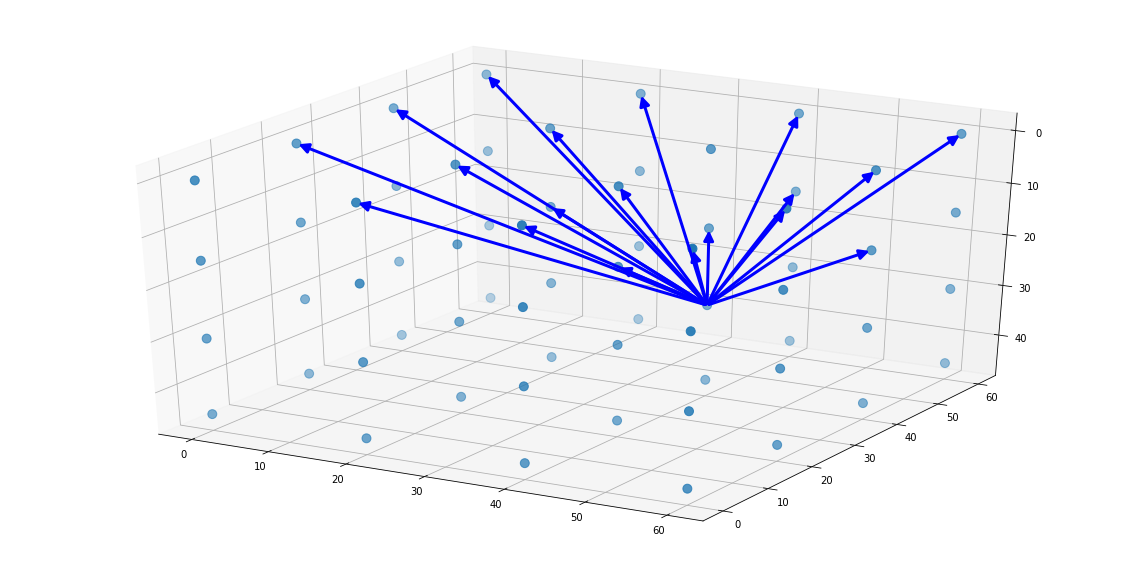

In [50]:
bloque_base = (3,3,3)
sacar = []
for arco in arcos:
    bloque_tail = arco[0]
    bloque_head = arco[1]
    if bloque_base==bloque_tail:
        sacar.append(bloque_head)
# sacar_pred: lista que tiene sacar predecesores
sacar_pred = [bloque for bloque in S[bloque_base]]

MB_grafico = MB_sorted[['xcentre','ycentre','zcentre']]-(min(MB_sorted[['xcentre']].values),min(MB_sorted[['ycentre']].values),min(MB_sorted[['zcentre']].values))
ejex = MB_grafico[['xcentre']]
ejey = MB_grafico[['ycentre']]
ejez = MB_grafico[['zcentre']]

# graficar arrcos para sacar
# bloque_base
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.gca().invert_zaxis()

#for v in sacar:
#    a = Arrow3D([(bloque_base[0]-1)*20, (v[0]-1)*20], [(bloque_base[1]-1)*20, (v[1]-1)*20], 
#                [(bloque_base[2]-1)*15, (v[2]-1)*15], mutation_scale=20, 
#                lw=3, arrowstyle="-|>", color="r")
#    ax.add_artist(a)
for v in sacar_pred:
    a = Arrow3D([(bloque_base[0]-1)*20, (v[0]-1)*20], [(bloque_base[1]-1)*20, (v[1]-1)*20], 
                [(bloque_base[2]-1)*15, (v[2]-1)*15], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="b")
    ax.add_artist(a)
ax.scatter(ejex,ejey,ejez,s=80)

In [52]:
(1,3,1) in [v[1] for v in arcos if v[0]==(2,3,2)]

True

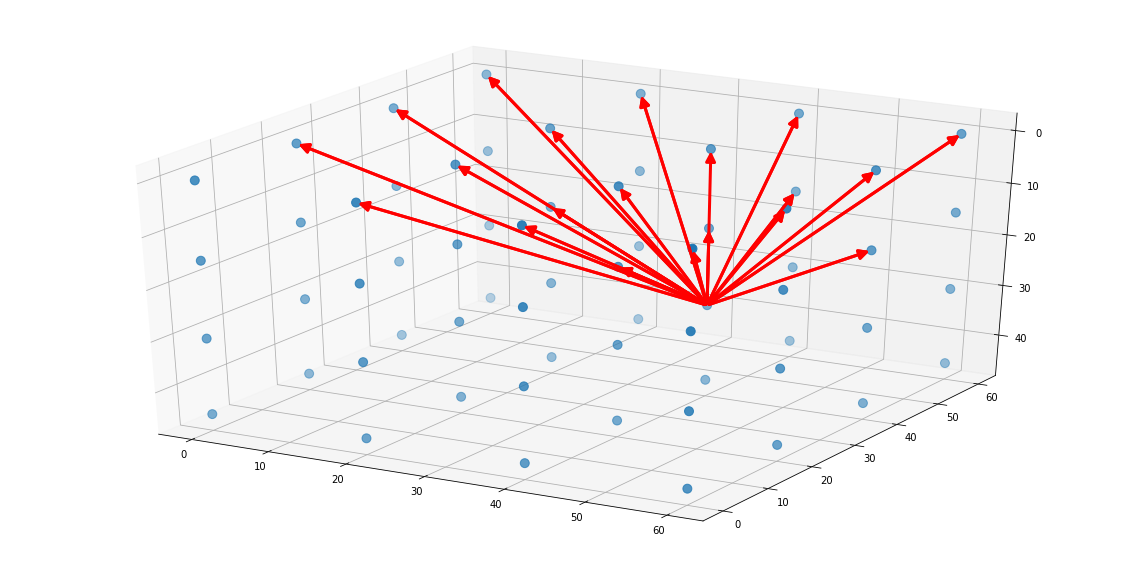

In [51]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.gca().invert_zaxis()

for v in sacar:
    a = Arrow3D([(bloque_base[0]-1)*20, (v[0]-1)*20], [(bloque_base[1]-1)*20, (v[1]-1)*20], 
                [(bloque_base[2]-1)*15, (v[2]-1)*15], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.scatter(ejex,ejey,ejez,s=80)

In [6]:
# Lerchs & Grossmann
ejex_MB = MB.sort_values(by=['xcentre'], ascending=False)[['xcentre']]
ejey_MB = MB.sort_values(by=['ycentre'], ascending=False)[['ycentre']]
ejez_MB = MB.sort_values(by=['zcentre'], ascending=False)[['zcentre']]
pos_x_MB = np.unique(ejex_MB.values)
pos_y_MB = np.unique(ejey_MB.values)
pos_z_MB = np.unique(ejez_MB.values)


Nx = 5# numero de ptos pos dimension
Ny = 5
Nz = 5
MB_sorted = MB.sort_values(by=['zcentre'], ascending=False)
# MB_sorted = MB_sorted.loc[MB_sorted['zcentre'] < pos_z_MB[N]]
# MB_sorted = MB_sorted.loc[MB_sorted['xcentre'] < pos_x_MB[N]]
# MB_sorted = MB_sorted.loc[MB_sorted['ycentre'] < pos_y_MB[N]]

MB_sorted = MB_sorted.loc[MB_sorted['zcentre'] < pos_z_MB[Nz]]
MB_sorted = MB_sorted.loc[MB_sorted['xcentre'] < pos_x_MB[Nx]]
MB_sorted = MB_sorted.loc[MB_sorted['ycentre'] < pos_y_MB[Ny]]
print(list(MB_sorted))
V = dicc()
# agregar nodo artificial de LG
V[0] = 'vo'
A = list()
for tail in range(1, Numx*Numy*Numz+1):
    for head in S[V[tail]]:
        A.append()

['xcentre', 'ycentre', 'zcentre', 'calcosina', 'cut', 'cufe', 'rec_max_block']
(72610.0, 477970.0, 462.5)
(72630.0, 477970.0, 462.5)
(72650.0, 477950.0, 462.5)
(72610.0, 477950.0, 462.5)
(72630.0, 477950.0, 462.5)
(72670.0, 477950.0, 462.5)
(72650.0, 477970.0, 462.5)
(72690.0, 477970.0, 462.5)
(72670.0, 477970.0, 462.5)
(72690.0, 477950.0, 462.5)
(72650.0, 477910.0, 462.5)
(72670.0, 477910.0, 462.5)
(72650.0, 477930.0, 462.5)
(72610.0, 477910.0, 462.5)
(72630.0, 477910.0, 462.5)
(72610.0, 477930.0, 462.5)
(72630.0, 477930.0, 462.5)
(72670.0, 477930.0, 462.5)
(72690.0, 477910.0, 462.5)
(72690.0, 477930.0, 462.5)
(72650.0, 477990.0, 462.5)
(72630.0, 477990.0, 462.5)
(72610.0, 477990.0, 462.5)
(72670.0, 477990.0, 462.5)
(72690.0, 477990.0, 462.5)
(72690.0, 477990.0, 447.5)
(72610.0, 477990.0, 447.5)
(72630.0, 477990.0, 447.5)
(72650.0, 477990.0, 447.5)
(72670.0, 477990.0, 447.5)
(72690.0, 477910.0, 447.5)
(72690.0, 477930.0, 447.5)
(72670.0, 477930.0, 447.5)
(72610.0, 477910.0, 447.5)
(72

In [15]:
if (2,3,4) is True:
    print('hola')